<a href="https://colab.research.google.com/github/ahmeterdem/FLOWERFLOPEN/blob/main/MyProjectv1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/adap/flower/tree/main/examples/vertical-fl

Cloning into 'vertical-fl'...
fatal: repository 'https://github.com/adap/flower/tree/main/examples/vertical-fl/' not found


Kütüphaneler

In [ ]:
!pip install -q flwr[simulation] flwr_datasets[vision] torch torchvision matplotlib scikit-learn numpy pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.1/330.1 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 MB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed

Task

In [ ]:
import torch.nn as nn
import numpy as np
import pandas as pd


def _bin_age(age_series):
    bins = [-np.inf, 10, 40, np.inf]
    labels = ["Child", "Adult", "Elderly"]
    return (
        pd.cut(age_series, bins=bins, labels=labels, right=True)
        .astype(str)
        .replace("nan", "Unknown")
    )


def _extract_title(name_series):
    titles = name_series.str.extract(" ([A-Za-z]+)\.", expand=False)
    rare_titles = {
        "Lady",
        "Countess",
        "Capt",
        "Col",
        "Don",
        "Dr",
        "Major",
        "Rev",
        "Sir",
        "Jonkheer",
        "Dona",
    }
    titles = titles.replace(list(rare_titles), "Rare")
    titles = titles.replace({"Mlle": "Miss", "Ms": "Miss", "Mme": "Mrs"})
    return titles


def _create_features(df):
    # Convert 'Age' to numeric, coercing errors to NaN
    df["Age"] = pd.to_numeric(df["Age"], errors="coerce")
    df["Age"] = _bin_age(df["Age"])
    df["Cabin"] = df["Cabin"].str[0].fillna("Unknown")
    df["Title"] = _extract_title(df["Name"])
    df.drop(columns=["PassengerId", "Name", "Ticket"], inplace=True)
    all_keywords = set(df.columns)
    df = pd.get_dummies(
        df, columns=["Sex", "Pclass", "Embarked", "Title", "Cabin", "Age"]
    )
    return df, all_keywords


def get_partitions_and_label():
    df = pd.read_csv("_static/data/train.csv")
    processed_df = df.dropna(subset=["Embarked", "Fare"]).copy()
    processed_df, all_keywords = _create_features(processed_df)
    raw_partitions = _partition_data(processed_df, all_keywords)

    partitions = []
    for partition in raw_partitions:
        partitions.append(partition.drop("Survived", axis=1))
    return partitions, processed_df["Survived"].values


def _partition_data(df, all_keywords):
    partitions = []
    keywords_sets = [{"Parch", "Cabin", "Pclass"}, {"Sex", "Title"}]
    keywords_sets.append(all_keywords - keywords_sets[0] - keywords_sets[1])

    for keywords in keywords_sets:
        partitions.append(
            df[
                list(
                    {
                        col
                        for col in df.columns
                        for kw in keywords
                        if kw in col or "Survived" in col
                    }
                )
            ]
        )

    return partitions


class ClientModel(nn.Module):
    def __init__(self, input_size):
        super(ClientModel, self).__init__()
        self.fc = nn.Linear(input_size, 4)

    def forward(self, x):
        return self.fc(x)

Client

In [ ]:
import flwr as fl
import torch
from sklearn.preprocessing import StandardScaler

# from task import ClientModel


class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, data):
        self.cid = cid
        self.train = torch.tensor(StandardScaler().fit_transform(data)).float()
        self.model = ClientModel(input_size=self.train.shape[1])
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=0.01)
        self.embedding = self.model(self.train)

    def get_parameters(self, config):
        pass

    def fit(self, parameters, config):
        self.embedding = self.model(self.train)
        return [self.embedding.detach().numpy()], 1, {}

    def evaluate(self, parameters, config):
        self.model.zero_grad()
        self.embedding.backward(torch.from_numpy(parameters[int(self.cid)]))
        self.optimizer.step()
        return 0.0, 1, {}

Strategy

In [ ]:
import flwr as fl
import torch
import torch.nn as nn
import torch.optim as optim
from flwr.common import ndarrays_to_parameters, parameters_to_ndarrays


class ServerModel(nn.Module):
    def __init__(self, input_size):
        super(ServerModel, self).__init__()
        self.fc = nn.Linear(input_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc(x)
        return self.sigmoid(x)


class Strategy(fl.server.strategy.FedAvg):
    def __init__(
        self,
        labels,
        *,
        fraction_fit=1,
        fraction_evaluate=1,
        min_fit_clients=2,
        min_evaluate_clients=2,
        min_available_clients=2,
        evaluate_fn=None,
        on_fit_config_fn=None,
        on_evaluate_config_fn=None,
        accept_failures=True,
        initial_parameters=None,
        fit_metrics_aggregation_fn=None,
        evaluate_metrics_aggregation_fn=None,
    ) -> None:
        super().__init__(
            fraction_fit=fraction_fit,
            fraction_evaluate=fraction_evaluate,
            min_fit_clients=min_fit_clients,
            min_evaluate_clients=min_evaluate_clients,
            min_available_clients=min_available_clients,
            evaluate_fn=evaluate_fn,
            on_fit_config_fn=on_fit_config_fn,
            on_evaluate_config_fn=on_evaluate_config_fn,
            accept_failures=accept_failures,
            initial_parameters=initial_parameters,
            fit_metrics_aggregation_fn=fit_metrics_aggregation_fn,
            evaluate_metrics_aggregation_fn=evaluate_metrics_aggregation_fn,
        )
        self.model = ServerModel(12)
        self.initial_parameters = ndarrays_to_parameters(
            [val.cpu().numpy() for _, val in self.model.state_dict().items()]
        )
        self.optimizer = optim.SGD(self.model.parameters(), lr=0.01)
        self.criterion = nn.BCELoss()
        self.label = torch.tensor(labels).float().unsqueeze(1)

    def aggregate_fit(
        self,
        rnd,
        results,
        failures,
    ):
        # Do not aggregate if there are failures and failures are not accepted
        if not self.accept_failures and failures:
            return None, {}

        # Convert results
        embedding_results = [
            torch.from_numpy(parameters_to_ndarrays(fit_res.parameters)[0])
            for _, fit_res in results
        ]
        embeddings_aggregated = torch.cat(embedding_results, dim=1)
        embedding_server = embeddings_aggregated.detach().requires_grad_()
        output = self.model(embedding_server)
        loss = self.criterion(output, self.label)
        loss.backward()

        self.optimizer.step()
        self.optimizer.zero_grad()

        grads = embedding_server.grad.split([4, 4, 4], dim=1)
        np_grads = [grad.numpy() for grad in grads]
        parameters_aggregated = ndarrays_to_parameters(np_grads)

        with torch.no_grad():
            correct = 0
            output = self.model(embedding_server)
            predicted = (output > 0.5).float()

            correct += (predicted == self.label).sum().item()

            accuracy = correct / len(self.label) * 100

        metrics_aggregated = {"accuracy": accuracy}

        return parameters_aggregated, metrics_aggregated

    def aggregate_evaluate(
        self,
        rnd,
        results,
        failures,
    ):
        return None, {}

Simulation

In [ ]:
import flwr as fl
import numpy as np
#from strategy import Strategy
#from client import FlowerClient
from pathlib import Path
#from task import get_partitions_and_label

partitions, label = get_partitions_and_label()


def client_fn(cid):
    return FlowerClient(cid, partitions[int(cid)]).to_client()


# Start Flower server
hist = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=3,
    config=fl.server.ServerConfig(num_rounds=1000),
    strategy=Strategy(label),
)

results_dir = Path("_static/results")
results_dir.mkdir(exist_ok=True)
np.save(str(results_dir / "hist.npy"), hist)

Streaming output truncated to the last 5000 lines.
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO:flwr:aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 752]
INFO:flwr:[ROUND 752]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO:flwr:configure_fit: strategy sampled 3 clients (out of 3)
INFO :      aggregate_fit: received 3 results and 0 failures
INFO:flwr:aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO:flwr:configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO:flwr:aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 753]
INFO:flwr:[ROUND 753]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO:flwr:configure_fit: strategy sampled 3 clients (out of 3)
INFO :      aggregate_fit: received

Plot

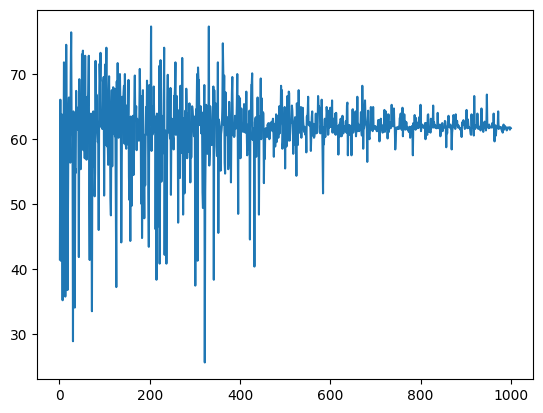

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

if __name__ == "__main__":
    hist = np.load("_static/results/hist.npy", allow_pickle=True).item()
    rounds, values = zip(*hist.metrics_distributed_fit["accuracy"])
    plt.plot(np.asarray(rounds), np.asarray(values))
    plt.savefig("_static/results/accuracy.png")